In [1]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, HTML


<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
    }
</style>

In [2]:
# data downloaded from NASA:
# https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
# and stored in directory cmapsdata

#bunch of setup
%matplotlib inline
#sns.set()
inputdir = "cmapsdata" 

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [3]:
for i in range(1, 4):
    print("Ops_"+str(i))

Ops_1
Ops_2
Ops_3


# Preparing datasets

In [4]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]

column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'/train_FD001.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'/test_FD001.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

In [5]:
df_train

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Computing RUL and flagging all failure cases in the training set

In [6]:
#count cycle time
max_cycle = df_train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

# merge the max cycle back into the original frame
train_merged = df_train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')

# calculate RUL for each row
Target_RUL = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_merged["Target_RUL"] = Target_RUL

# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)

# flag failures
train_with_target["IsFailure"] = train_with_target['Target_RUL'] == 0

#show the table
train_with_target.head()

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_RUL,IsFailure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,False
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,False
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,False
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,False
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,False


We can now easily collect the features of failure cases in the training set

In [7]:
train_with_target[train_with_target['IsFailure'] == True].head()

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_RUL,IsFailure
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,0,True
478,2,287,-0.0005,0.0006,100.0,518.67,643.85,1608.50,1430.84,14.62,...,8175.57,8.5365,0.03,398,2388,100.0,38.43,23.0848,0,True
657,3,179,0.0012,0.0000,100.0,518.67,643.51,1604.80,1428.23,14.62,...,8255.34,8.5056,0.03,398,2388,100.0,38.40,22.9562,0,True
846,4,189,-0.0024,-0.0002,100.0,518.67,644.53,1612.11,1432.55,14.62,...,8259.42,8.5246,0.03,398,2388,100.0,38.44,23.1006,0,True
1115,5,269,0.0022,0.0003,100.0,518.67,643.46,1597.28,1430.74,14.62,...,8212.75,8.5209,0.03,397,2388,100.0,38.45,23.0296,0,True


Let's first visualize failure and non-failure cases. 

We will use PCA to reduce the dimension and then plot the failure cases, which shall help in the future path of this study.

In [8]:
#let's build feature set X and label Y
to_drop = ['UnitNumber', 'Cycle', 'Target_RUL', 'IsFailure']
X = train_with_target.drop(to_drop, axis = 1)
Y = train_with_target['IsFailure']
RUL = train_with_target['Target_RUL']

# Dimensionality Reduction with PCA

In [9]:
#fit PCA with 2 components
pca_comp = 2
pca = PCA(n_components=pca_comp)
pca.fit(X)

#transform feature with this model
X_pca = pca.transform(X)

#distinguish features based on label
X_failures = X_pca[Y, :]
X_nonfailures = X_pca[~Y, :]

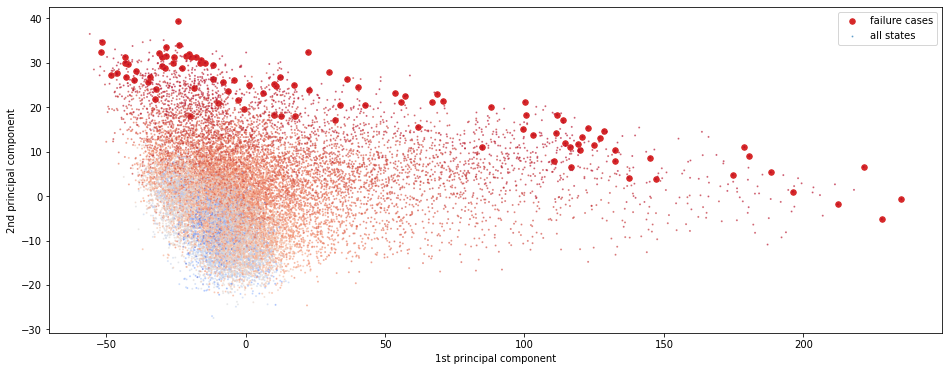

In [10]:
#plot
fig, ax = plt.subplots(figsize=(16, 6))
#ax.scatter(X_nonfailures[:,0], X_nonfailures[:,1], s=1, label="non failure cases")
ax.scatter(X_failures[:,0], X_failures[:,1], c="C3", s=30, label="failure cases")
ax.scatter(X_pca[:,0], X_pca[:,1], c=-RUL, s=1, cmap="coolwarm", alpha=0.5, label="all states")
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
plt.legend()

plt.show()

**Checking $\Delta X$**

In [11]:
UnitNumber = train_with_target["UnitNumber"]
X_1 = X_pca[UnitNumber==1,:]

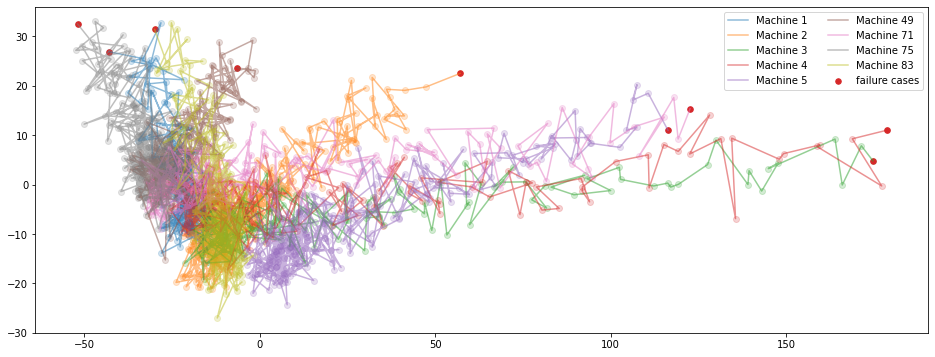

In [12]:
#plot
plt.figure(figsize=(16, 6))
#ax.scatter(X_nonfailures[:,0], X_nonfailures[:,1], s=1, label="non failure cases")


i=1
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30, label="failure cases")

i=2
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)

i=3
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)

i=4
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)


i=5
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)



i=49#np.random.randint(1, 100)
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)


i=71#np.random.randint(1, 100)
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)

i=75#np.random.randint(1, 100)
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)


i=83#np.random.randint(1, 100)
plt.plot(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.5, label='Machine '+str(i))
plt.scatter(X_pca[UnitNumber==i,0], X_pca[UnitNumber==i,1], alpha=0.2)
plt.scatter(X_failures[i-1,0], X_failures[i-1,1], c="C3", s=30)


#ax.set_xlabel('1st principal component')
#ax.set_ylabel('2nd principal component')
plt.legend(ncol=2)

plt.show()

## Survival model

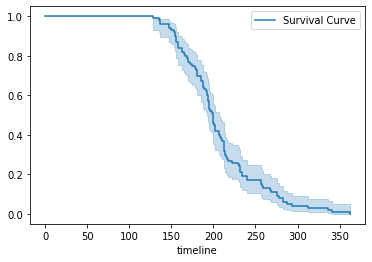

In [13]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

## instantiate the class to create an object
kmf = KaplanMeierFitter() 

durations = max_cycle['MaxOfCycle']
events = np.ones(durations.shape)

## fit KaplanMeierFitter model for all machines
kmf.fit(durations, events, label='Survival Curve')
a1 = kmf.plot()

In [14]:
#let's build feature set X and label Y
to_drop = ['UnitNumber', 'Cycle', 'IsFailure', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 
           'Sensor_1', 'Sensor_5', 'Sensor_6', 'Sensor_10', 'Sensor_16', 'Sensor_18', 'Sensor_19']
X = train_with_target.drop(to_drop, axis = 1)
X = X.loc[train_with_target['Cycle']==1,:]
X['Flag'] = 1
X

,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,Target_RUL,Flag
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,1
192,641.89,1583.84,1391.28,554.53,2388.01,9054.72,46.93,522.33,2388.06,8137.72,8.3905,391,38.94,23.4585,286,1
479,642.04,1584.20,1398.13,553.96,2388.06,9056.95,47.14,522.24,2388.00,8138.40,8.4207,391,38.96,23.3205,178,1
658,642.60,1585.40,1402.85,553.97,2388.06,9051.10,47.29,521.94,2388.07,8131.50,8.4200,393,39.04,23.3814,188,1
847,641.77,1583.59,1395.26,554.39,2387.98,9066.49,47.19,522.34,2388.00,8152.22,8.4102,393,38.98,23.4468,268,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19552,642.03,1579.12,1404.22,554.92,2388.11,9046.49,47.41,522.26,2388.06,8133.36,8.4293,392,38.82,23.4178,335,1
19888,642.01,1581.83,1395.40,554.31,2388.04,9044.30,47.21,522.34,2388.05,8130.81,8.4027,391,38.94,23.3732,201,1
20090,642.30,1580.93,1404.55,554.16,2388.00,9073.83,47.25,522.30,2387.97,8150.69,8.3792,392,39.01,23.4547,155,1
20246,641.69,1586.17,1391.14,554.09,2388.03,9064.32,47.41,522.65,2388.06,8131.23,8.4038,391,39.01,23.4007,184,1


In [15]:
cph = CoxPHFitter()

## fit KaplanMeierFitter model for all machines
cph.fit(X, 'Target_RUL', event_col='Flag')   
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 100 total observations, 0 right-censored observations>
             duration col = 'Target_RUL'
                event col = 'Flag'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 100
   partial log-likelihood = -353.63
         time fit was run = 2020-09-23 20:16:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    0.82       2.27       0.39             0.06             1.59                 1.06                 4.89
Sensor_3    0.04       1.04       0.02            -0.01             0.08                 0.99                 1.09
Sensor_4    0.03       1.03       0.03            -0.03             0.08                 0.97                 1.08
Sensor_7   -0.06       0.94       0.26            -0.57             0.46                 0.57                 1.58
Sensor_8   -2.70       0.07       3.57            -9.69             4.29                 0.00                72.63
Sensor_9   -0.06       0.95       0.03            -0.11             0.00                 0.90                 1.00
Sensor_11  -0.23       0.79       1.09            -2.38             1.91                 0.09                 6.77
Sensor_12  -0.57       0.57       0.34            -1.22             0.09                 0.29                 1.09
Sensor_13  -3.76       0.02       3.80           -11.20             3.68                 0.00                39.69
Sensor_14   0.06       1.06       0.03             0.00             0.11                 1.00                 1.12
Sensor_15   3.26      26.03       5.49            -7.51            14.03                 0.00             1.23e+06
Sensor_17   0.08       1.08       0.11            -0.14             0.31                 0.87                 1.36
Sensor_20   1.51       4.53       1.11            -0.66             3.68                 0.52                39.53
Sensor_21  -1.19       0.30       1.98            -5.08             2.70                 0.01                14.83

              z    p   -log2(p)
covariate                      
Sensor_2   2.10 0.04       4.82
Sensor_3   1.47 0.14       2.83
Sensor_4   0.98 0.33       1.61
Sensor_7  -0.22 0.83       0.28
Sensor_8  -0.76 0.45       1.16
Sensor_9  -1.95 0.05       4.29
Sensor_11 -0.21 0.83       0.27
Sensor_12 -1.69 0.09       3.46
Sensor_13 -0.99 0.32       1.63
Sensor_14  2.12 0.03       4.86
Sensor_15  0.59 0.55       0.85
Sensor_17  0.70 0.48       1.05
Sensor_20  1.37 0.17       2.54
Sensor_21 -0.60 0.55       0.87
---
Concordance = 0.64
Partial AIC = 735.27
log-likelihood ratio test = 20.21 on 14 df
-log2(p) of ll-ratio test = 3.02

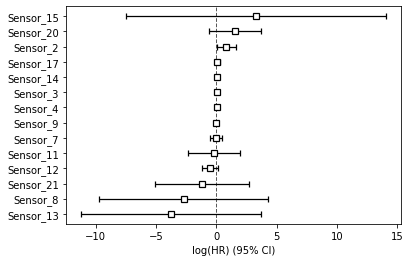

In [16]:
cph.plot()
plt.show()






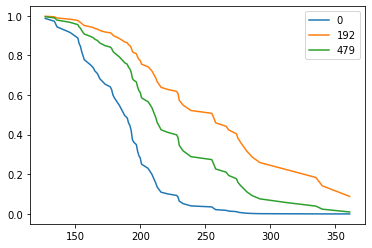

In [17]:
#tr_rows = df_dummy.iloc[5:10, 2:]
to_drop = ['Target_RUL', 'Flag']
X_pred = X.drop(to_drop, axis = 1)
tr_rows = X_pred.iloc[0:3,:]

cph.predict_survival_function(tr_rows).plot()

plt.show()

In [18]:
to_drop = ['UnitNumber', 'Cycle', 'IsFailure', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 
           'Sensor_1', 'Sensor_5', 'Sensor_6', 'Sensor_10', 'Sensor_16', 'Sensor_18', 'Sensor_19',
          'Target_RUL']
#X = train_with_target.drop(to_drop, axis = 1)
X = train_with_target
X['ID'] = X['UnitNumber']
X['Flag'] = X['IsFailure']
X['Cycle_Start'] = X['Cycle']
X['Cycle_End'] = X['Cycle']+1

X = X.drop(to_drop, axis = 1)
X

,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,ID,Flag,Cycle_Start,Cycle_End
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,1,False,1,2
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,1,False,2,3
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,1,False,3,4
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,1,False,4,5
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,1,False,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,100,False,196,197
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,100,False,197,198
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,100,False,198,199
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,100,False,199,200


## Time Varying Model

In [19]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(X, id_col="ID", event_col="Flag", start_col="Cycle_Start", stop_col="Cycle_End", show_progress=True)
ctv.print_summary()

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -323.99756, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 20631 periods, 100 subjects, 100 events>
         event col = 'Flag'
         penalizer = 0.1
number of subjects = 100
 number of periods = 20631
  number of events = 100
partial log-likelihood = -324.00
  time fit was run = 2020-09-23 20:16:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    0.09       1.09       0.04             0.00             0.17                 1.00                 1.19
Sensor_3    0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
Sensor_4    0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
Sensor_7   -0.06       0.95       0.02            -0.10            -0.01                 0.90                 0.99
Sensor_8    0.71       2.03       0.30             0.11             1.30                 1.12                 3.67
Sensor_9    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Sensor_11   0.19       1.21       0.08             0.03             0.35                 1.03                 1.42
Sensor_12  -0.07       0.93       0.03            -0.13            -0.01                 0.88                 0.99
Sensor_13   0.73       2.07       0.30             0.14             1.31                 1.15                 3.71
Sensor_14   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Sensor_15   1.20       3.33       0.58             0.07             2.34                 1.07                10.34
Sensor_17   0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
Sensor_20  -0.28       0.76       0.12            -0.51            -0.04                 0.60                 0.96
Sensor_21  -0.42       0.66       0.20            -0.81            -0.02                 0.45                 0.98

              z    p   -log2(p)
covariate                      
Sensor_2   2.06 0.04       4.66
Sensor_3   1.77 0.08       3.71
Sensor_4   2.48 0.01       6.24
Sensor_7  -2.27 0.02       5.44
Sensor_8   2.33 0.02       5.65
Sensor_9   1.33 0.18       2.45
Sensor_11  2.38 0.02       5.86
Sensor_12 -2.40 0.02       5.92
Sensor_13  2.42 0.02       6.03
Sensor_14  1.06 0.29       1.79
Sensor_15  2.08 0.04       4.74
Sensor_17  2.07 0.04       4.69
Sensor_20 -2.31 0.02       5.60
Sensor_21 -2.08 0.04       4.74
---
Partial AIC = 676.00
log-likelihood ratio test = 79.48 on 14 df
-log2(p) of ll-ratio test = 34.72

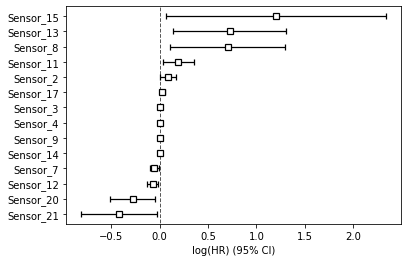

In [20]:
ctv.plot()

In [21]:
X
#tr_rows = df_dummy.iloc[5:10, 2:]
to_drop = ['Cycle_Start', 'Cycle_End','Flag','ID']
X_pred = X.drop(to_drop, axis = 1)
tr_rows = X_pred.iloc[np.array(X['ID']==1), :]
tr_rows
#ctv.predict_expectation(tr_rows)



,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,643.75,1602.38,1422.78,551.94,2388.31,9037.91,48.00,519.79,2388.23,8117.69,8.5207,396,38.51,22.9588
188,644.18,1596.17,1428.01,550.70,2388.27,9044.55,48.08,519.58,2388.33,8117.51,8.5183,395,38.48,23.1127
189,643.64,1599.22,1425.95,551.29,2388.29,9040.58,48.33,520.04,2388.35,8112.58,8.5223,398,38.49,23.0675
190,643.34,1602.36,1425.77,550.92,2388.28,9042.76,48.15,519.57,2388.30,8114.61,8.5174,394,38.45,23.1295
